In [1]:
import numpy as np
from numba import njit

In [2]:
# Model parameters
median = 1.75/1000
γ = 0.018
τ = median * γ
δ = 0.01
η = 0.032
ξ_m = 0.00256

μ_2 = 1.
ρ = 0.5
σ_2 = np.sqrt((0.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

Equation:

\begin{align*}
0 &= \max_{e}\min_{h_2} -\delta \phi(y, z_2) + \delta \eta \log e -\delta(1-\eta)y z_2 + \xi_m \frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y,z_2) e - \ell e\\
&+\left[\frac{\partial \phi}{\partial z_2}(y,z_2)\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(y,z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

FOC for $h_2$ gives:
$$
h^* = -\frac{\frac{\partial \phi}{\partial z_2}(y,z_2)\sqrt{z_2}\sigma_2}{\xi_m}
$$

FOC for $e$ gives:
$$
e^* = \frac{\delta \eta}{\ell - \frac{\partial \phi}{\partial y}(y, z_2)}
$$

Solve:

\begin{align*}
\frac{\color{red}{\phi_{i+1}(y,z_2)}-\color{blue}{\phi_{i}(y,z_2)}}{\epsilon} &= -\delta \color{red}{\phi(y, z_2)} + \delta \eta \log \color{blue}{e^*} -\delta(1-\eta)y z_2 + \xi_m \frac{(\color{blue}{h_2^*})^2}{2}  + \color{red}{\frac{\partial \phi}{\partial y}(y,z_2)} e\\
&+\left[\color{red}{\frac{\partial \phi}{\partial z_2}(y,z_2)}\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 \color{blue}{h_2^*}\right] + \left[\color{red}{\frac{\partial^2 \phi}{\partial(z_2)^2}(y,z_2)}\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

In [3]:
# @njit(parallel=True, cache=True)
def solver(ϕ_grid, y_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ):
    n_y = len(y_grid)
    n_z = len(z_grid)
    Δ_y = y_grid[1] - y_grid[0]
    Δ_z = z_grid[1] - z_grid[0]
    LHS = np.zeros((n_y*n_z, n_y*n_z))
    RHS = np.zeros(n_y*n_z)
#     e_min = 0.
#     e_max = 0.
    for j in range(n_z):
        for i in range(n_y):
            idx = j*n_y + i
            idx_yp1 = idx + 1
            idx_ym1 = idx - 1
            idx_zp1 = (j+1)*n_y + i
            idx_zp2 = (j+2)*n_y + i
            idx_zm1 = (j-1)*n_y + i
            idx_zm2 = (j-2)*n_y + i
            ϕ = ϕ_grid[idx]
            z = z_grid[j]
            y = y_grid[i]
            LHS[idx, idx] += - 1./ϵ - δ
            if i == 0:
                dϕdy = (ϕ_grid[idx_yp1]-ϕ_grid[idx])/Δ_y
                e = δ*η/(ℓ-dϕdy)
                LHS[idx, idx] += -e/Δ_y
                LHS[idx, idx_yp1] += e/Δ_y
            elif i == n_y-1:
                dϕdy = (ϕ_grid[idx]-ϕ_grid[idx_ym1])/Δ_y
                e = δ*η/(ℓ-dϕdy)
                LHS[idx, idx] += e/Δ_y
                LHS[idx, idx_ym1] += -e/Δ_y
            else:
                dϕdy = (ϕ_grid[idx_yp1]-ϕ_grid[idx_ym1])/(2*Δ_y)
                e = δ*η/(ℓ-dϕdy)
                LHS[idx, idx] += -e/Δ_y
                LHS[idx, idx_yp1] += e/Δ_y
#             print(e)
#             print(i, j, e, dϕdy)
#             if e < e_min:
#                 e_min = e
#             elif e > e_max:
#                 e_max = e
            temp_2 = z*σ_2**2/2
            if j == 0:
                dϕdz = (ϕ_grid[idx_zp1]-ϕ_grid[idx])/Δ_z
                h = -dϕdz*np.sqrt(z)*σ_2/ξ_m
                temp_1 = -ρ*(z-μ_2) + np.sqrt(z)*σ_2*h
                LHS[idx, idx] += -temp_1/Δ_z + temp_2/(Δ_z**2)  
                LHS[idx, idx_zp1] += temp_1/Δ_z - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zp2] += temp_2/(Δ_z**2)
            elif j == n_z-1:
                dϕdz = (ϕ_grid[idx]-ϕ_grid[idx_zm1])/Δ_z
                h = -dϕdz*np.sqrt(z)*σ_2/ξ_m
                temp_1 = -ρ*(z-μ_2) + np.sqrt(z)*σ_2*h
                LHS[idx, idx] += temp_1/Δ_z + temp_2/(Δ_z**2)
                LHS[idx, idx_zm1] += -temp_1/Δ_z - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zm2] += temp_2/(Δ_z**2)            
            else:
                dϕdz = (ϕ_grid[idx_zp1]-ϕ_grid[idx_zm1])/(2*Δ_z)
                h = -dϕdz*np.sqrt(z)*σ_2/ξ_m
                temp_1 = -ρ*(z-μ_2) + np.sqrt(z)*σ_2*h
                LHS[idx, idx] += temp_1/Δ_z*(-1.*(temp_1>0)+(temp_1<0)) - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zp1] += temp_1/Δ_z*(temp_1>0) + temp_2/(Δ_z**2)
                LHS[idx, idx_zm1] += -temp_1/Δ_z*(temp_1<0) + temp_2/(Δ_z**2)
            RHS[idx] = -(1./ϵ*ϕ + δ*η*np.log(e) - δ*(1-η)*y*z + ξ_m*h**2/2)
    ϕ_grid = np.linalg.solve(LHS, RHS)
#     print(e_min, e_max)
    return ϕ_grid


# @njit
def false_transient(ϕ_grid, b_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ, max_iter=10_000, tol=1e-9):
    error = 1.
    count = 0
    while error > tol and count < max_iter:
        ϕ_grid_old = ϕ_grid.copy()
        ϕ_grid = solver(ϕ_grid, b_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ)
        error = np.max(np.abs(ϕ_grid_old-ϕ_grid))/ϵ
        count += 1
        print('Iteration:', count, ', error:', error)
    return ϕ_grid

In [4]:
ϵ = 0.1
y_max = 3000.
z_max = 2.0
n_y = 400
n_z = 20
y_grid = np.linspace(1e-2, y_max, n_y)
z_grid = np.linspace(1e-5, z_max, n_z)
ϕ_grid = np.zeros(n_y*n_z) # initial guess

(y_mat, z_mat) = np.meshgrid(y_grid, z_grid, indexing = 'ij')
ϕ_grid = -δ*η*y_mat.reshape(-1,order='F')

In [5]:
ℓ = 0
ϕ_grid = false_transient(ϕ_grid, y_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ, max_iter=2, tol=1e-7)

Iteration: 1 , error: 56.63438814685286
Iteration: 2 , error: 13776.199695711084


In [ ]:
ϕ_grid_2 = solver(ϕ_grid_1, y_grid, z_grid, ℓ, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ)

In [ ]:
ϕ_grid_2

In [9]:
ϕ = ϕ_grid.reshape((n_y, n_z),order='F')
Δ_y = y_grid[1] - y_grid[0]
dϕdr = np.zeros_like(ϕ)
for j in range(n_z):
    for i in range(n_y):
        if i == 0:
            dϕdr[i, j] = (ϕ[i+1, j] - ϕ[i, j])/Δ_y
        elif i == n_y-1:
            dϕdr[i, j] = (ϕ[i, j] - ϕ[i-1, j])/Δ_y
        else:
            dϕdr[i, j] = (ϕ[i+1, j] - ϕ[i-1, j])/(2*Δ_y)

In [ ]:
dϕdr[180, :]

In [6]:
import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter

# fig = plt.figure()
# ax = fig.gca(projection='3d')

# # Make data.
# X, Y = np.meshgrid(y_grid, z_grid)
# Z = dϕdr.T

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# # ax.set_zlim(-1.01, 1.01)
# # ax.zaxis.set_major_locator(LinearLocator(10))
# # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()

Text(0.5, 0, 'y')

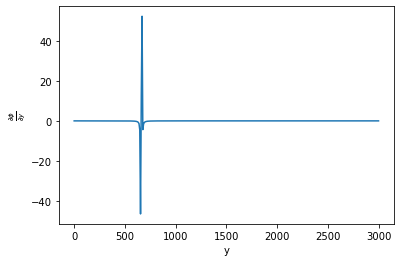

In [14]:
# plt.plot(y_grid, dϕdr[:, 0])
plt.plot(y_grid, dϕdr[:, 10])
# plt.plot(y_grid, dϕdr[:, 19])
plt.ylabel(r'$\frac{\partial \phi}{\partial y}$')
plt.xlabel('y')
# plt.savefig('plot.pdf')

In [ ]:
ϕ_grid

In [ ]:
ϕ_grid = ϕ_grid.reshape((n_r, n_z), order='F')

In [ ]:
# Compute e_grid conditioned on z2
z_loc = 10
z = z_grid[z_loc]
Δ_r = r_grid[1] - r_grid[0]
dϕdr = np.zeros_like(r_grid) 
for i in range(n_r):
    if i == 0:
        dϕdr[i] = (ϕ[i+1, z_loc] - ϕ[i, z_loc])/Δ_r
    elif i == n_r-1:
        dϕdr[i] = (ϕ[i, z_loc] - ϕ[i-1, z_loc])/Δ_r
    else:
        dϕdr[i] = (ϕ[i+1, z_loc] - ϕ[i-1, z_loc])/(2*Δ_r)
e_grid = δ*η/(τ*z + dϕdr)

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(e_grid)
# plt.ylim(0, 20)

In [ ]:
plt.plot(ϕ[:,0])
plt.ylim(0, 0.05)

In [ ]:
ϕ[:, 10]

In [ ]:
import pickle

In [ ]:
with open('solu_modified_40200_0900', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
ϕ_suri = b['phi']

In [ ]:
plt.plot(ϕ_suri[0, :])
plt.ylim(0, 0.05)

In [ ]:
ϕ_suri_new = ϕ_suri.T.reshape(-1, order='F')

In [ ]:
res = solver(ϕ_suri_new, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ)

In [ ]:
np.abs(np.max((res - ϕ_suri_new)/ϵ))